In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model, pipeline, feature_extraction, ensemble, neighbors, tree
from sklearn.decomposition import LatentDirichletAllocation
import string
import sys
import warnings
warnings.filterwarnings("ignore")
import pprint

In [3]:
from src.item_recommender import ItemRecommender

In [4]:
# importing the data
initial_data = pd.read_csv('data/winemag-data-130k-v2.csv')

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [6]:
initial_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [8]:
# Dropping column information I do not need or want to use
new_df = initial_data.drop(['region_1', 'region_2', 'designation', 'province', 'taster_twitter_handle'], axis=1)

In [9]:
new_df.head()

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [9]:
# Checking for information that is missing
new_df.isna().sum()

Unnamed: 0            0
country              63
description           0
points                0
price              8996
taster_name       26244
title                 0
variety               1
winery                0
winery_variety        1
dtype: int64

In [10]:
# Eliminating any duplicate review entries
new_df = new_df.drop_duplicates('description', keep='first')

In [13]:
new_df.shape

(119955, 9)

In [14]:
new_df.isna().sum()

Unnamed: 0         0
country           59
description        0
points             0
price           8388
taster_name    24912
title              0
variety            1
winery             0
dtype: int64

In [15]:
# Dropping entries with missing information
new_df.dropna(axis=0, inplace=True)
new_df.shape

(88244, 9)

In [16]:
# Checking to make sure there are no missing values one last time
new_df.isna().sum()

Unnamed: 0     0
country        0
description    0
points         0
price          0
taster_name    0
title          0
variety        0
winery         0
dtype: int64

# TF IDF Recommendation

In [17]:
# Custom list of stop words so I can focus on unique, descriptive words associated with different wine varieties 

extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc', 'merlot', 'pinot', 'chardonnay','noir','cabernet','sauvignon', 'bordeaux','riesling','syrah','viognier', 'wine', 'flavors', 'fruit', 'palate','finish','aromas','notes','drink','years','good','like','nose','ripe','acidity',]
stop = set(stopwords.words('english'))
stop.update(extras)

In [19]:
# Using 50,000 wine reviews for my final dataset
sample = new_df.head(50000)

47484


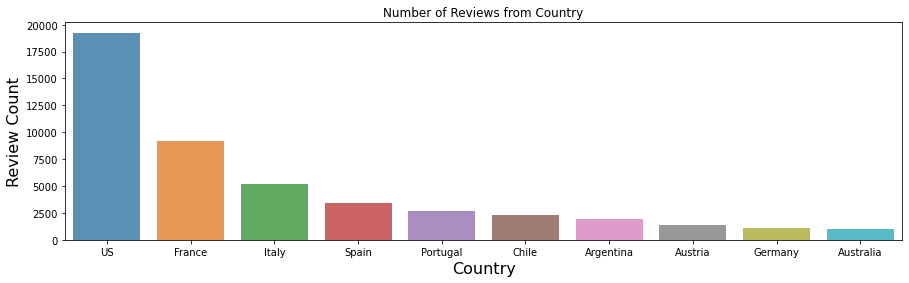

In [21]:
# Exploring where the different vineyards operate
country_count = sample['country'].value_counts()

country_count = country_count[:10]
print(sum(country_count))
plt.figure(figsize=(15,4))
sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title('Number of Reviews from Country')
plt.ylabel('Review Count', fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.show()

In [22]:
# Average score of a wine review
sample['points'].describe()

count    50000.000000
mean        88.540140
std          2.971761
min         80.000000
25%         86.000000
50%         88.000000
75%         91.000000
max        100.000000
Name: points, dtype: float64

Text(0.5, 1.0, 'Length of Wine Reviews')

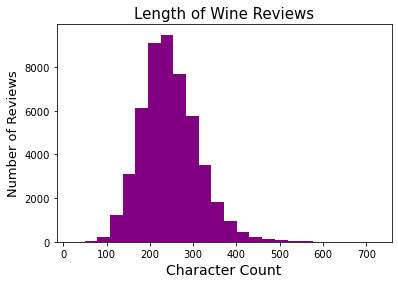

In [23]:
# Checking how long a wine review is
plt.hist([len(i) for i in sample['description']], 24, facecolor='purple')
plt.xlabel('Character Count', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=13)
plt.title('Length of Wine Reviews', fontsize=15)

In [24]:
# Seeing how many kinds of wine there are in the dataset
variety_count = sample['variety'].value_counts()

len(variety_count)

565

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Instantiate the tf idf vectorizer
tf = TfidfVectorizer(stop_words=stop, ngram_range=(1,2), max_df=.2)

# Put the wine descriptions through the vectorizer and create tf idf matrix
tfidf_matrix = tf.fit_transform(sample.description)


tfidf_cosine_similarity = cosine_similarity(tfidf_matrix)


In [26]:
tfidf_matrix.shape

(50000, 473410)

In [27]:
# Fitting the tfidf matrix throught the ItemRecommeder, which is located in the src folder,
# and instantiating the wine's title as input
wine_recommender = ItemRecommender()
wine_recommender.fit(tfidf_matrix, sample.title)

In [26]:
# Getting a recommendation based on the title of a bottle from the dataset using tf idf model
print(wine_recommender.get_recommendations('Hindsight 2013 Bella Vetta Vineyard Cabernet Sauvignon (Howell Mountain)'))

['Kuleto Estate 2013 Cabernet Sauvignon (Napa Valley)'
 'Proulx 2012 Pinot Noir (Central Coast)'
 'Davis Family 2012 Horseshoe Bend Vineyard Pinot Noir (Russian River Valley)'
 'Davies 2013 Red Cap Vineyard Cabernet Sauvignon (Howell Mountain)'
 "Ghost Pines 2015 Winemaker's Reserve Zinfandel (Sonoma County-San Joaquin County)"]


# SKLearn LDA 

In [28]:
# I chose 10, 20, and 30 components with the results on in the result.ipynb file for my LDA model
n_components = 10
lda = LatentDirichletAllocation(n_components)
topic_values = lda.fit_transform(tfidf_matrix)

In [29]:
lda.components_.shape

(10, 473410)

In [30]:
# Running the recommender on the LDA model
wine_recommender = ItemRecommender()
wine_recommender.fit(topic_values, sample.title)

In [31]:
# Getting a recommendation for the wine using the LDA model
print(wine_recommender.get_recommendations('Hindsight 2013 Bella Vetta Vineyard Cabernet Sauvignon (Howell Mountain)'))

['Woodward Canyon 2011 Artist Series 20th Anniversary Cabernet Sauvignon (Washington)'
 'Leeuwin Estate 2012 Art Series Cabernet Sauvignon (Margaret River)'
 'Edmeades 2013 Petite Sirah (Mendocino County)'
 'Château de la Liquiere 2008 Vieilles Vignes Red (Faugères)'
 'Della 2015 Pinot Noir (Sonoma Coast)']


In [34]:
# Pulling out the words used to make up the different topics using the LDA model
vocab = tf.get_feature_names()

n_top_words = 10
n_topics = n_components

topic_words = {}

for topic, comp in enumerate(lda.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    
    topic_words[topic] = [vocab[i] for i in word_idx]

In [35]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
display_topics(lda, vocab, num_top_words)

Topic 0:
black full fresh light apple fruits rich texture berry soft
Topic 1:
black alongside offers berry black cherry spice note opens pepper hint
Topic 2:
black full apple spice fresh rich oak well bodied light
Topic 3:
black berry fruits fresh full plum light rich spice well
Topic 4:
black full fresh rich plum light fruits texture dry spice
Topic 5:
black fresh fruits dry light full well plum soft rich
Topic 6:
black fresh fruits full light dry rich well fruity apple
Topic 7:
black plum fruits light rich berry full soft dry apple
Topic 8:
black full soft apple fruits fresh spice crisp rich texture
Topic 9:
black fresh full berry fruits oak spice plum light bodied
